<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/Hall/Hall_cold_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4 Hall: Measurements on cold sample


Evgeny Kolonsky 2025

v.0.1.0


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import requests

# The procedure outline

1. Collect data at zero magnetic field to extract misalignment voltage $U_m$ slope and offset, and get initial **resistivity** $\rho_0$:
$$
U_m = \beta U_p + U_0,
$$
$$
\rho = \frac{U_p}{I_p}  \frac{W d}{L}, \quad B=0.
$$
with $W=10$ mm, $L=16$ mm, $d=1$ mm
2. Collect data at various $B$ and $I_p$.
3. Extract **Hall coefficent** $R_H$ from $U_H$ vs $B\cdot I_p$:
$$
R_H = \frac{U_H \cdot d}{B\cdot I_p}
$$
4. Calculate **Hall mobility**
$$
\mu_H = \frac{R_H}{\rho}
$$
5. Independently find **magnetoresistance** $\mu_p$:
$$
\frac{\rho(B) - \rho|_{B=0}}{\rho|_{B=0}} \approx (\mu_p B)^2
$$
6. Compute the **Hall factor** $r_H$:
$$
r_H = \frac{\mu_H}{\mu_p}.
$$

Expected value at 300K is about $r_H=1.8$. [source: Ioffe](https://www.ioffe.ru/SVA/NSM/Semicond/Ge/electric.html)

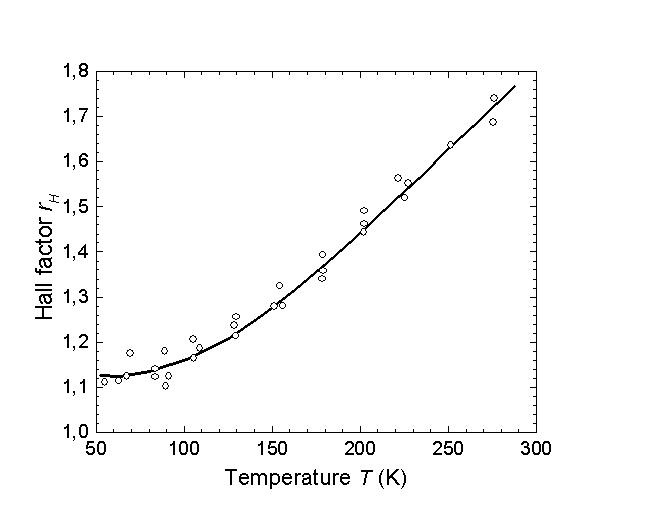

# Step 1. Zero magnetic field




In [2]:
# Constants
W = 10e-3 #mm
L = 16e-3 #mm
d = 1e-3  #mm

Slope beta = 0.049, offset U0 = -0.1 mV
Resistance rho = 0.030 Ohm m


Text(0, 0.5, 'Observed Hall voltage $U_H$, mV')

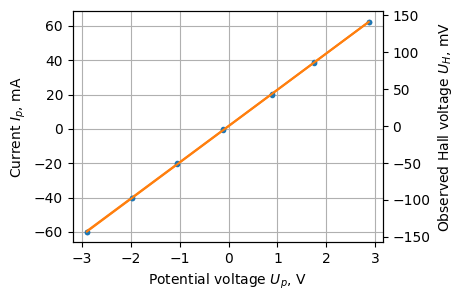

In [73]:
zero = '''
#B = 0
# Ip/mA, Up/mV, Uh/mV
-60 -2900 -143.38
-40 -1983 -97.30
-20 -1046 -51.36
0.01 -106 -5.25
20 891 43.83
39 1754 86.20
62 2869 141.20
'''

Ip, Up, Uh = np.genfromtxt(zero.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax1 = ax.twinx()
fit_conductivity = linregress(Up, Ip)
fit_leak = linregress(Up, Uh)
beta, U0 = fit_leak.slope, fit_leak.intercept
print(f'Slope beta = {beta:.3f}, offset U0 = {U0*1e3:.1f} mV')

R = 1 /  fit_conductivity.slope
rho = R * W * d / L
print(f'Resistance rho = {rho:.3f} Ohm m')

ax.plot(Up, Ip*1e3, '.')
ax.plot(Up, 1e3*(fit_conductivity.intercept + fit_conductivity.slope * Up))
ax.set_xlabel(r'Potential voltage $U_p$, V')
ax.set_ylabel(r"Current $I_p$, mA")
ax.grid()


ax1.plot(Up, Uh*1e3, '.')
ax1.plot(Up, (beta*Up + U0)*1e3)
ax1.set_ylabel(r"Observed Hall voltage $U_H$, mV")


## Step 2. Measurements at non-zero magnetic field



In [74]:
def weighted_average(values, errors):
  weights = 1 / errors**2
  average  = np.sum(weights * values) / np.sum(weights)
  error_of_average = np.sqrt(1 / np.sum(weights))
  return average, error_of_average

### Getting raw data

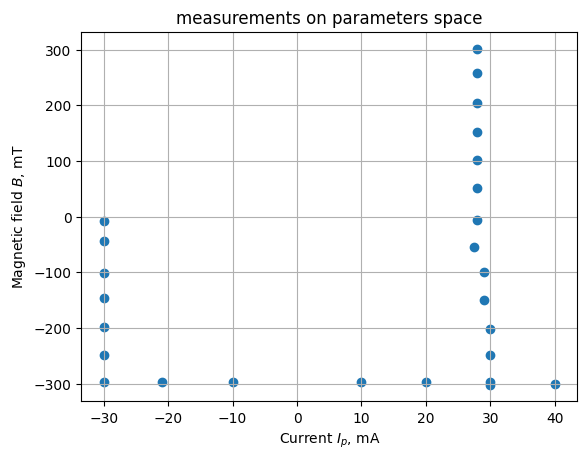

In [75]:
data = '''
# Ip/mA, Up/mV, Uh/mV, B/mT
30 1350 8.89 302
30 1338 17.45 248
30 1329 25.28 202
29 1320 34.67 150
29 1315 44.11 100
27.5 1244 50.60 54
28 1242 59.74 6
28 1242 71.28 -51
28 1244 80.85 -101
28 1250 90.56 -152
28 1257 99.98 -204
28 1265 109.50 -259
28 1272 116.62 -302
40 1854 12.86 300
30 1394 9.89 298
20 894 6.34 297
10 466 3.29 297
#0 -53 -0.33 297
-10 -574 -3.98 297
-21 -1106 -7.77 297
-30 -1521 -10.76 297
-30 -1507 -19.71 248
-30 -1495 -29.23 198
-30 -1485 -39.64 147
-30 -1479 -49.21 101
-30 -1472 -62.14 44
-30 -1470 -70.53 7
'''
Ip, Up, Uh, B = np.genfromtxt(data.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3
B *= -1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up
B_err = 5e-3 # let's assume error in B is 5 mT
B_rel = B_err / B

plt.scatter(Ip*1e3, B*1e3)
plt.xlabel(r'Current $I_p$, mA')
plt.ylabel(r'Magnetic field $B$, mT')
plt.title('measurements on parameters space')
plt.grid()

# Step 3. Extract $R_H$ after zero correction
$$
R_H = \frac{U_H \cdot d}{B\cdot I_p}
$$

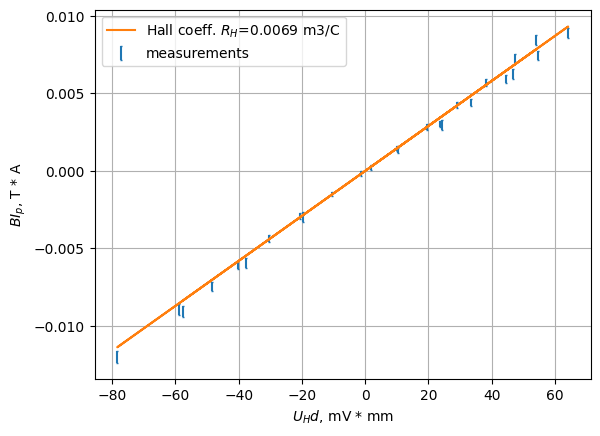

In [76]:
# hall voltage zero correction
Uh_ = Uh - beta * Up - U0


y = B * Ip
# relative error
y_rel = np.sqrt(B_rel**2 + Ip_rel**2)
y_err = np.abs(y * y_rel)
# Error by x is negligible
x = Uh_ * d
k, k_error  = weighted_average(y/x, y_err/x)
k_rel = np.abs(k_error / k)
RH = 1 / k
RH_err =  RH * k_rel

plt.errorbar(x*1e6, y, yerr=y_err,  capsize=1, linestyle='', label='measurements')
plt.plot(x*1e6, (k * x), label=fr'Hall coeff. $R_H$={RH:.4f} m3/C')
plt.grid()
plt.ylabel(r'$B I_p$, T * A')
plt.xlabel(r'$U_H d$, mV * mm')

plt.legend()

In [77]:
print(f'Measured value RH = {RH*1e3:.2f} ± {RH_err*1e3:.2f} 10^-3 m3/C')

Measured value RH = 6.89 ± 0.07 10^-3 m3/C


#  Step  4. Calculate Hall mobility
$$
\mu_H = \frac{R_H}{\rho}
$$

<TBD>

In [78]:
mu_H = RH / rho
print(f'Measured value mu_H = {mu_H:.2f} m2 / Vs')

Measured value mu_H = 0.23 m2 / Vs


#Step 5. Find magnetoresistance $\mu_p$:
$$
\frac{\rho(B) - \rho|_{B=0}}{\rho|_{B=0}} \approx (\mu_p B)^2
$$

Measured value mu_p = 0.06 +- 0.07 m2 / Vs


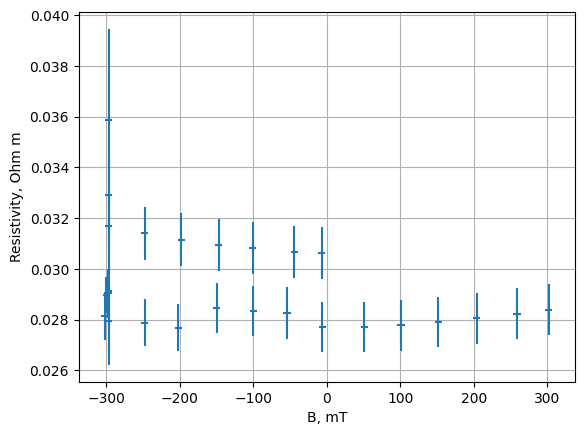

In [89]:
data = '''
# Ip/mA, Up/mV, Uh/mV, B/mT
30 1350 8.89 302
30 1338 17.45 248
30 1329 25.28 202
29 1320 34.67 150
29 1315 44.11 100
27.5 1244 50.60 54
28 1242 59.74 6
28 1242 71.28 -51
28 1244 80.85 -101
28 1250 90.56 -152
28 1257 99.98 -204
28 1265 109.50 -259
28 1272 116.62 -302
40 1854 12.86 300
30 1394 9.89 298
20 894 6.34 297
10 466 3.29 297
#0 -53 -0.33 297
-10 -574 -3.98 297
-21 -1106 -7.77 297
-30 -1521 -10.76 297
-30 -1507 -19.71 248
-30 -1495 -29.23 198
-30 -1485 -39.64 147
-30 -1479 -49.21 101
-30 -1472 -62.14 44
-30 -1470 -70.53 7
'''
Ip, Up, Uh, B = np.genfromtxt(data.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3
B *= -1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up
B_err = 5e-3 # let's assume error in B is 5 mT
B_rel = B_err / B

rhoB =  Up/Ip * W * d / L
rhoB_rel = Ip_rel
rhoB_err = np.abs(rhoB * rhoB_rel)
plt.errorbar(B*1e3, rhoB, yerr=rhoB_err, xerr=B_err*1e3, linestyle='')

def model(x, a, offset):
  return (a * x)**2 + offset

parameters, parameters_covariance = curve_fit(model, B, rhoB, sigma=rhoB_err)

mu_p = parameters[0]
mu_p_err = np.sqrt(np.diag(parameters_covariance))[0]
print(f'Measured value mu_p = {mu_p:.2f} +- {mu_p_err:.2f} m2 / Vs')
#plt.plot(B*1e3, model(B, *parameters))
plt.xlabel('B, mT')
plt.ylabel('Resistivity, Ohm m')
plt.grid()

Magnetoresistance can not be extracted from data with given current measurement accuracy.

#Step 6. Compute the Hall factor $r_H$:
$$
r_H = \frac{\mu_H}{\mu_p}.
$$

In [80]:
r_H = mu_H / mu_p
print(f'Measured value r_H = {r_H:.2f}')

Measured value r_H = 2.14


### Conclusion

Measurements at zero magnetic field should be performed before loading the sample with magnetic field to find true zero and apply zero correction.

Results with zero correction are consistent with the linear model.